In [1]:
import os
import re
import numpy as np
import pandas as pd
from scipy.stats import linregress
import matplotlib.pyplot as plt

In [2]:
LIT_PATH = 'data/literature_t0/'
TC_PATH = 'data/t0/'

In [13]:
literature = {}
for file in sorted(os.listdir(LIT_PATH)):
    element = file.strip('.xlsx')
    if element != 'La':
        literature[element] = pd.read_excel(os.path.join(LIT_PATH, file))

thermocalc = {}
for file in sorted(os.listdir(TC_PATH)):
    element = file.strip('.csv')
    thermocalc[element] = pd.read_csv(os.path.join(TC_PATH, file), index_col=0)

In [7]:
LABEL_COLORS = {
    'Af (C)': '#d62728',
#     'As (C)': '#1f77b4',
#     'Ms (C)': '#ff7f0e',
#     'Mf (C)': '#2ca02c',
}

In [5]:
def plot_regression(x, y, ax, color=None):
    slope, intercept, *_ = linregress(x, y)
    
    regression = lambda x: slope * x + intercept
    y_pred = regression(x)
    
    ax.plot(x, y_pred, color=color, label='_nolegend_')
    return regression

def to_mol_percent_ab(df, element):
    x = df.index / 100

    s = df.index.name
    a = re.findall(element + '(\d)O', s)
    b = re.findall('O(\d)', s)
    if len(a) == 0:
        a = [1]
    
    if len(b) == 0:
        b = [1]
    
    a, b = int(a[0]), int(b[0])
    
    return 100 * a * x / (3 - (a + b - 3) * x)

def to_mol_percent(df, element):
    x = df.index / 100

    s = df.index.name
    a = re.findall(element + '(\d)O', s)

    if len(a) == 0:
        return 100 * x
    
    a = int(a[0])
    
#     return 100 * x / (2 - x)
    return 100 * a * x / (1 + a * x)


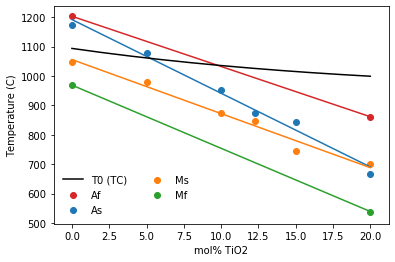

In [6]:
fig, ax = plt.subplots()

df = literature['Ti']
mean = df.groupby(df.columns[0]).mean()

for label, color in LABEL_COLORS.items():
    x = to_mol_percent(mean[label].dropna(), 'Ti')
    y = mean[label].dropna().values

    ax.scatter(
        x, y,
        label=label.strip(' (C)'),
        color=color
    )
    plot_regression(
        x, y,
        ax,
        color
    )

tc = thermocalc['Ti']
xtc = to_mol_percent(tc, 'Ti')
ax.plot(
    xtc, tc['T0 (K)'] - 273,
    'k-',
    label='T0 (TC)'
)
ax.legend(frameon=False, ncol=2, loc='lower left')

ax.set_xlabel(df.columns[0])
ax.set_ylabel('Temperature (C)')
plt.show()

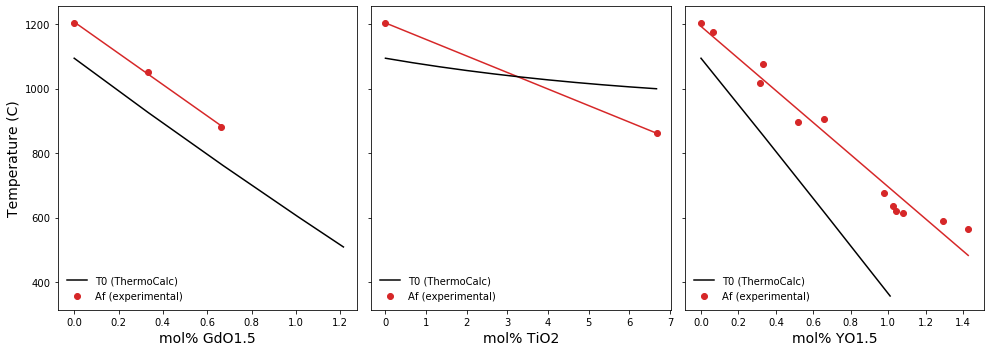

In [19]:
fig, ax_fig = plt.subplots(1, 3, figsize=(14, 5), sharey=True)

for (element, df), ax in zip(literature.items(), ax_fig.reshape(-1)):

    mean = df.groupby(df.columns[0]).mean()

    for label, color in LABEL_COLORS.items():
        x = to_mol_percent_ab(mean[label].dropna(), element)
        y = mean[label].dropna().values

        ax.scatter(
            x, y,
            label=label.strip(' (C)') + ' (experimental)',
            color=color
        )
        plot_regression(
            x, y,
            ax,
            color
        )

    tc = thermocalc[element]
    xtc = to_mol_percent_ab(tc, element)
    ax.plot(
        xtc, tc['T0 (K)'] - 273,
        'k-',
        label='T0 (ThermoCalc)'
    )
    ax.legend(frameon=False, ncol=1, loc='lower left')

    ax.set_xlabel(df.columns[0], fontsize=14)
    
ax_fig[0].set_ylabel('Temperature (C)', fontsize=14)
fig.tight_layout()
plt.show()

#### Correcting the temperature: constant shift

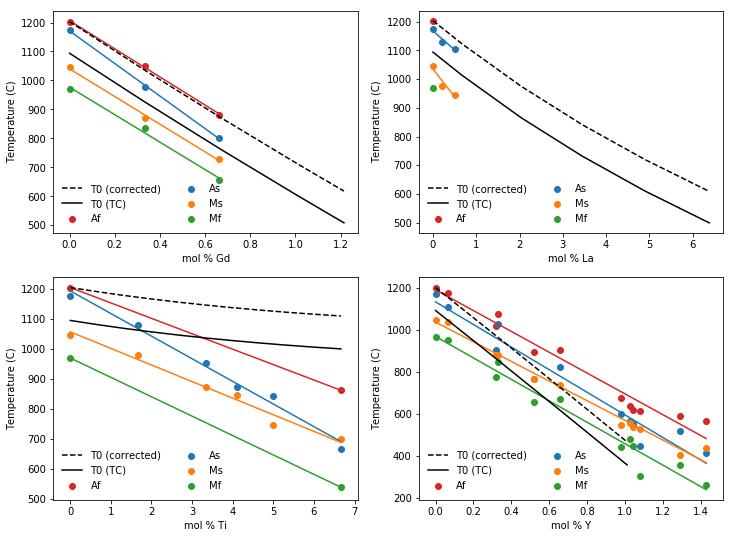

In [61]:
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 9))

for (element, df), ax in zip(literature.items(), ax_fig.reshape(-1)):

    mean = df.groupby(df.columns[0]).mean()

    for label, color in LABEL_COLORS.items():
        x = to_mol_percent_ab(mean[label].dropna(), element)
        y = mean[label].dropna().values

        ax.scatter(
            x, y,
            label=label.strip(' (C)'),
            color=color
        )
        plot_regression(
            x, y,
            ax,
            color
        )

    tc = thermocalc[element]
    tc['T0 (C)'] = tc['T0 (K)'] - 273
#     tc['Af (C, expt)'] = 
    tc['T0 (C, corr)'] = tc['T0 (C)'] + (mean.loc[0]['Af (C)'] - tc.loc[0]['T0 (C)'])
    
    xtc = to_mol_percent_ab(tc, element)
    ax.plot(
        xtc, tc['T0 (C, corr)'],
        'k--',
        label='T0 (corrected)'
    )
    
    ax.plot(
        xtc, tc['T0 (C)'],
        'k-',
        label='T0 (TC)'
    )
    
    ax.legend(frameon=False, ncol=2, loc='lower left')

    ax.set_xlabel('mol %% %s' % element)
    ax.set_ylabel('Temperature (C)')
plt.show()

In [67]:
SHIFT = (tc['T0 (C, corr)'] - tc['T0 (C)']).loc[0]

#### Applying the experimental values

In [76]:
for element, df in literature.items():

    tc = thermocalc[element]
    mean = df.groupby(df.columns[0]).mean()
    
    label = 'Af (C)'
    x = to_mol_percent_ab(mean[label].dropna(), element)
    y = mean[label].dropna().values

    slope, intercept, *_ = linregress(x, y)
    
    if not any([np.isnan(z) for z in [slope, intercept]]):
        regression = lambda x: slope * x + intercept    
        tc['Af (C, expt)'] = regression(to_mol_percent_ab(tc, element))
    else:
        tc['Af (C, expt)'] = tc['T0 (C)'] + SHIFT

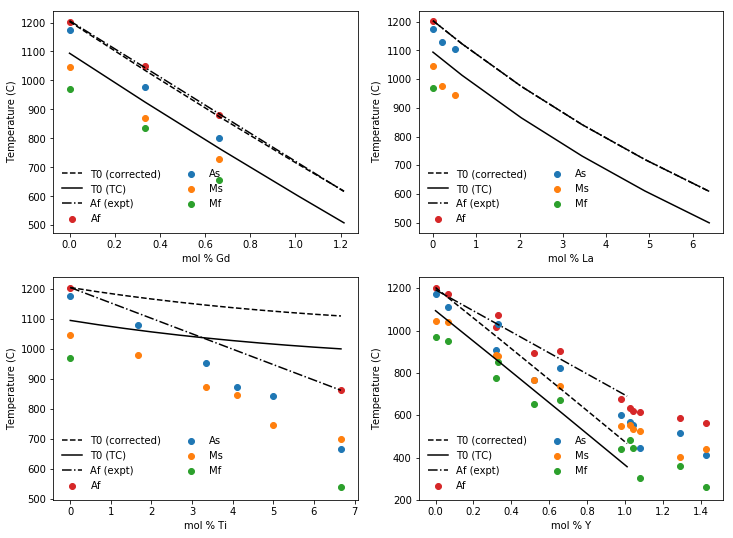

In [78]:
fig, ax_fig = plt.subplots(2, 2, figsize=(12, 9))

for (element, df), ax in zip(literature.items(), ax_fig.reshape(-1)):

    mean = df.groupby(df.columns[0]).mean()

    for label, color in LABEL_COLORS.items():
        x = to_mol_percent_ab(mean[label].dropna(), element)
        y = mean[label].dropna().values

        ax.scatter(
            x, y,
            label=label.strip(' (C)'),
            color=color
        )
    
    tc = thermocalc[element]
    xtc = to_mol_percent_ab(tc, element)
    ax.plot(
        xtc, tc['T0 (C, corr)'],
        'k--',
        label='T0 (corrected)'
    )
    
    ax.plot(
        xtc, tc['T0 (C)'],
        'k-',
        label='T0 (TC)'
    )
    
    ax.plot(
        xtc, tc['Af (C, expt)'],
        'k-.',
        label='Af (expt)'
    )
    
    ax.legend(frameon=False, ncol=2, loc='lower left')

    ax.set_xlabel('mol %% %s' % element)
    ax.set_ylabel('Temperature (C)')
plt.show()

In [80]:
for element, tc in thermocalc.items():
    if 'T0 (C)' not in tc.columns:
        tc['T0 (C)'] = tc['T0 (K)'] - 273
    
    if 'T0 (C, corr)' not in tc.columns:
        tc['T0 (C, corr)'] = tc['T0 (C)'] + SHIFT

In [83]:
for element, tc in thermocalc.items():
    tc.to_csv('data/t0_corr/%s.csv' % element)

In [84]:
SHIFT

109.45617492701103